<a href="https://colab.research.google.com/github/larodriguezq/-kuramoto-tests/blob/main/Network_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Librerias

In [ ]:
import math
import torch
import torch.nn as nn
import einops
import torchvision
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF


# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
import numpy as np

from torchvision import transforms
from einops.layers.torch import Rearrange

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # media 0.1307 Desviación 0.3081
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Train dataset Total: {len(train_dataset)} \nTest dataset Total: {len(test_dataset)}")



#Divide el conjunto de datoss en 64 imagenes para entrenamiento y 1000 para test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


print(f"\ntrain_loader size: {len(train_loader)} \nTest test_loader size: {len(test_loader)}")

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
img =images[0] #Mascara
lab=labels[0]
print(f"Label: {lab}")
plt.imshow(img.squeeze(), cmap='gray', interpolation='none')
plt.show()

# Kuramoto

##k-layer


In [ ]:
def reshape(x, n):
  return einops.rearrange(x, 'b (c n) ... -> b c n ...', n=n)

def reshape_back(x):
  return einops.rearrange(x, 'b c n ... -> b (c n) ...')

def nrm(x):
  return torch.linalg.norm(x, dim=2)

def gaussian_kernel_2d(size, sigma):
    """Function to create a 2D Gaussian kernel."""
    kernel = np.fromfunction(
        lambda x, y: np.exp(
            -((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)
        ),
        (size, size),
    )
    return torch.Tensor(kernel)

#Función de activación según la (norma - media )/desviación -------------------------------------------------------------
class ModReLU(nn.Module):

    def __init__(self, n, ch, norm="gn"):
        super().__init__()
        self.n = n
        if norm == "bn":
            self.norm = nn.BatchNorm2d(ch // n)
        elif norm == "gn":
            self.norm = nn.GroupNorm(ch // n, ch // n)
        else:
            self.norm = nn.Identity()

    def forward(self, x):
        x = reshape(x, self.n) #(B,C//nc n, H, W) Convierte los canales en C//n grupos de n osciladores
        m = torch.linalg.norm(x, dim=2)  # [B C//n H, W] Calcula la magnitud de cada vector, norma euclidiana, qué tan fuerte vibra
        m = torch.nn.ReLU()(self.norm(m))  # No relu Normalización por batch (Se resta la media y divide por la desviación)
        x = m.unsqueeze(2) * F.normalize(x, dim=2) #Dirección unitaria, restaura la dimensión extra
        x = reshape_back(x)
        return x

# Construcción---------------------------------------------------------------------------------------
class KConv2d(nn.Module):

  def __init__(self, n, ch, connectivity='conv', ksize=3, init_omg=1.0, hw=(16,16), use_omega=True, use_omega_c=True):
    # connnectivity is either 'conv' or 'ca'
    super().__init__()
    assert (ch % n) == 0
    self.n = n
    self.ch = ch

    if connectivity == 'conv': #Aquí se define la conectividad entre los osciladores ----------------------------
      self.connectivity = nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False) # Contiene filtros entrenables que controlan la conectividad Jij, se actualizan mediante la retropropagación.
    elif connectivity == 'conv_mlp':
      self.connectivity = nn.Sequential(
          nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False),
          ModReLU(n, ch),
          nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False))
    else:
      raise NotImplementedError

    self.use_omega = use_omega
    self.use_omega_c = use_omega_c
    if use_omega or use_omega_c:
      if n == 2 :
        self.omg_param = nn.Parameter(torch.randn(ch//2, 2))
      else:
        self.omg_param = nn.Parameter(init_omg * (1/np.sqrt(n))* torch.randn(ch//n, n, n))

  def omg(self, p):
    if self.n==2:
      p = torch.linalg.norm(p, dim=1)
      return torch.stack(
          [torch.stack([torch.zeros_like(p), p], -1),
          torch.stack([-p, torch.zeros_like(p)], -1)],
              -1)
    else:
      return p - p.transpose(1, 2)

  def forward(self, x, c=None):
    y = self.connectivity(x)
    if c is not None:
      y = y + c
    y = reshape(y, self.n)
    x = reshape(x, self.n)

    omg_x = torch.einsum('cnm,bcmhw->bcnhw', self.omg(self.omg_param), x) if self.use_omega else torch.zeros_like(x)
    proj = y - torch.sum(y*x, 2, keepdim=True) * x
    if c is not None:
      c = reshape(c, self.n)
      omg_c = torch.einsum('cnm,bcmhw->bcnhw', self.omg(self.omg_param), c) if self.use_omega_c else torch.zeros_like(c)
      return reshape_back(omg_x + proj), reshape_back(omg_c)
    else:
      return reshape_back(omg_x + proj)

  def compute_energy(self, x, c=None):

    y = self.connectivity(x)
    y = y + c
    B = x.shape[0]
    return - torch.sum(x.view(B, -1) * y.view(B, -1), -1)


#dinámica--------------------------------------------------------------
class KBlock(nn.Module):

  def __init__(self, n, ch, connectivity='conv', T=4, ksize=7, init_omg=0.1, c_norm='gn', use_omega=True, use_omega_c=True):
    super().__init__()
    self.n = n
    self.ch = ch
    self.T = T
    self.kconv = KConv2d(n, ch, connectivity=connectivity, ksize=ksize, init_omg=init_omg, use_omega=use_omega, use_omega_c=use_omega_c)
    self.monitor_count = 0
    if c_norm == 'gn':
      self.c_norm = nn.GroupNorm(ch//n, ch)
    else:
      self.c_norm = lambda x: x

  def normalize(self, x, y=None):
    x = reshape(x, self.n)
    x = torch.nn.functional.normalize(x, dim=2)
    if y is not None:
      x = torch.linalg.norm(reshape(y, self.n), dim=2, keepdim=True) * x
    x = reshape_back(x)
    return x

  def monitor_norms(self, dt, c, x):

    def print_norm(x, name):
      x = x.view(x.shape[0], -1).detach()
      x = torch.linalg.norm(x, dim=1).mean(0)
      print(f"avg norms of {name}: {x:.6f}")
    for x, name in ((dt, 'dt'), (c, 'c'), (x, 'x')):
      print_norm(x, name)

  def forward(self, x, c, T, gamma, del_t=1.0, return_xs=False, return_es=False, T_noc=None):
    x = self.normalize(x)
    c = self.c_norm(c)
    xs = [x]
    es = []
    if return_es:
      energy = self.kconv.compute_energy(x, c)
      es.append(energy)

    if self.monitor_count >= 50:
      do_monitoring = False
      self.monitor_count = 0
    else:
      do_monitoring = False
      self.monitor_count += 1

    for t in range(T):
      dxdt, dcdt = self.kconv(x, c)
      _c = c + gamma*del_t*dcdt
      c = self.normalize(_c, c)
      x = x + gamma*del_t*dxdt
      x = self.normalize(x)

      if return_es:
        energy = self.kconv.compute_energy(x, c)
        es.append(energy)

      if return_xs:
        xs.append(x)

    if return_es:
      return x, xs, es
    else:
      return x, xs

## Normalización
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

# Inicialización y dinámica



In [ ]:
img_resized = TF.resize(img, [64, 64])       # [1, 64, 64]
img_channels = img_resized.repeat(4, 1, 1)   # [4, 64, 64]
c = img_channels.unsqueeze(0)*1# [1, 4, 64, 64] Añade una posición extra en


In [ ]:
import random

ch = 4
n = 4
h, w = 64, 64
T = 100

seed =1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.randn(seed)


kblock = KBlock(n=n, ch=ch, connectivity='conv', T=T, ksize=3, init_omg=0.1, c_norm=None, use_omega_c=False)

x = torch.randn(1, ch, h, w) #Estados iniciales aleatorios, fases
x, xs, es = kblock(x, c, T=T, gamma=0.7, del_t=0.9, return_xs=True, return_es=True)

##Energía

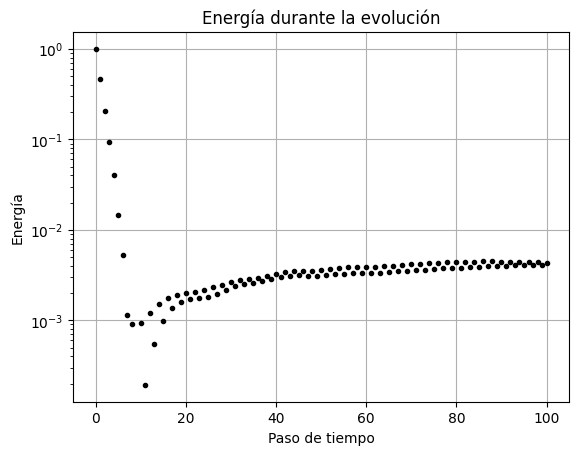

In [ ]:
energies = [e.item() for e in es]
energie_norm= (energies-np.min(energies))

plt.semilogy(energie_norm/np.max(energie_norm),'k.')
#plt.plot(energie_norm/np.max(energie_norm))
plt.title('Energía durante la evolución')
plt.xlabel('Paso de tiempo')
plt.ylabel('Energía')
plt.grid(True)
plt.show()



Cómo caracterizo el tiempo de sincronización?

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_dynamics(xs, channel=0, interval=100, filename='animacion.gif'):
    # Prepara los frames de la animación
    frames = [x[0, channel].detach().cpu().numpy() for x in xs]

    fig, ax = plt.subplots()
    img = ax.imshow(frames[0], animated=True)
    ax.axis('off')

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
    plt.close(fig)  # Oculta el gráfico estático

    # Guarda como GIF con Pillow
    ani.save(filename, writer='pillow', fps=1000//interval)
    print(f"Animación guardada como GIF en: {filename}")

    # También lo mostramos en Colab
    return HTML(ani.to_jshtml())

# Llama a la función
animate_dynamics(xs, channel=0, interval=100, filename='animacion.gif')


Animación guardada como GIF en: animacion.gif


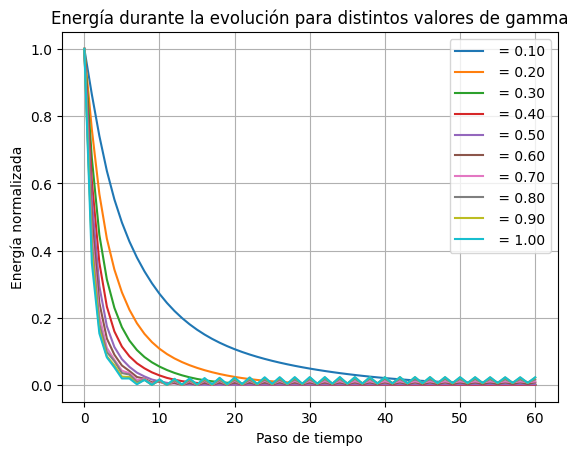

In [ ]:
inicio= 0.1
pasos= 0.1
fin= 1.0 + pasos


seed =1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.randn(seed)

a_array = np.arange(inicio, fin, pasos)  # Distintos valores de a
T=60

for a in a_array:
    # Estímulo con distinto valor de a
    c = img_channels.unsqueeze(0)   # [1, 4, 64, 64]
    x = torch.randn(1, ch, h, w)


    # Ejecutar bloque AKOrN
    x, xs, es = kblock(
        x, c, T=T, gamma=a, del_t=0.9,
        return_xs=True, return_es=True
    )

    # Energía durante la evolución
    energies = [e.item() for e in es]
    energie_norm = (energies - np.min(energies)) / np.max(energies - np.min(energies))

    # Graficar con etiqueta
    plt.plot(energie_norm, label=f' = {a:.2f}')
    #plt.loglog(energie_norm/np.max(energie_norm), label=f' = {a:.2f}')

# Mostrar el gráfico completo
plt.title('Energía durante la evolución para distintos valores de gamma')
plt.xlabel('Paso de tiempo')
plt.ylabel('Energía normalizada')
plt.grid(True)
plt.legend()

plt.savefig('energy.pdf')
plt.show()


Podemos observar que el parámetro gamma  del método de Euler afecta la dinámica de sincronización del sistema

In [ ]:
def compute_sync_parameter(x, n):
    """
    Calcula el parámetro de sincronización r(t) de un batch de osciladores.

    Args:
        x (Tensor): Tensor de forma [B, C, H, W], estados de los osciladores.
        n (int): Dimensión de cada oscilador (por ejemplo, n=2).

    Returns:
        Tensor de forma [B], con el valor r(t) para cada muestra del batch.
    """
    x = reshape(x, n)  # [B, C//n, n, H, W]
    x_mean = x.mean(dim=1)  # [B, n, H, W], promedio de osciladores por grupo
    r = torch.linalg.norm(x_mean, dim=1)  # [B, H, W], norma del vector promedio
    r_mean = r.mean(dim=(1, 2))  # [B], promedio sobre el plano espacial
    return r_mean

In [ ]:
kblock = KBlock(n=n, ch=ch, connectivity='conv', T=T, ksize=3, init_omg=0.1, c_norm=None, use_omega_c=False)

x = torch.randn(1, ch, h, w) #Estados iniciales aleatorios, fases
x, xs, es = kblock(x, c, T=T, gamma=0.1, del_t=0.9, return_xs=True, return_es=True)

In [ ]:
r_t = [compute_sync_parameter(x_t, n=2) for x_t in xs]

In [ ]:
r_avg = [r.mean().item() for r in r_t]

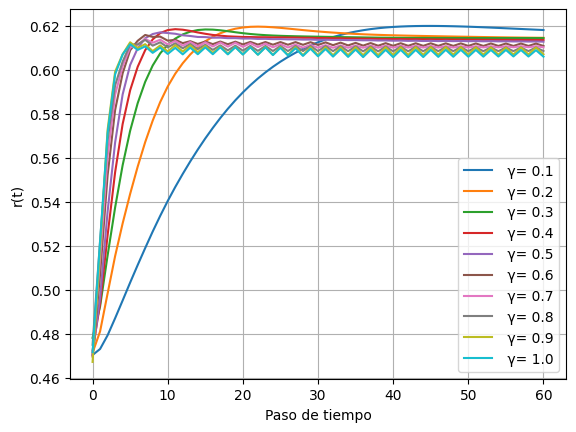

In [ ]:
inicio= 0.1
pasos= 0.1
fin= 1.0 + pasos


seed =1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.randn(seed)

a_array = np.arange(inicio, fin, pasos)  # Distintos valores de a
T=60

for a in a_array:
    # Estímulo con distinto valor de a
    c = img_channels.unsqueeze(0)   # [1, 4, 64, 64]
    x = torch.randn(1, ch, h, w)


    # Ejecutar bloque AKOrN
    x, xs, es = kblock(
        x, c, T=T, gamma=a, del_t=0.9,
        return_xs=True, return_es=True
    )

    # Energía durante la evolución
    r_t = [compute_sync_parameter(x_t, n=2) for x_t in xs]
    r_avg = [r.mean().item() for r in r_t]

    # Graficar con etiqueta
    plt.plot(r_avg, label=f' \u03B3= {round(a,2)}')


# Mostrar el gráfico completo
plt.xlabel('Paso de tiempo')
plt.ylabel('r(t)')
plt.grid(True)
plt.legend()

plt.savefig('sincronización.pdf')
plt.show()


#Red

**Objetivo: clasificar los número MNIST**

* ¿cómo puedo implementar una red neuronal adecuada para este modelo?

El modelo presenta buenos resultados para entrenamiento no supervizado. pero estoy utilizando un algoritmo para entrenamiento supervizado

Como puedo medir el efecto de la sincronización (tiempo de sincronización) sobre el aprendizaje -> variando el gamma de los pasos de Euler

comparación con una red neuronal tradicional para clasificación de números



##Arquitectura

In [ ]:
#Con la clase modrelu

class AKoRNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.modrelu = ModReLU(n=2, ch=16)  #
        self.kblock = KBlock(n=2, ch=16, T=10, ksize=5)  # T=4 iteraciones dinámicas
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.modrelu(x)  # Aplica ModReLU en lugar de nn.ReLU()
        x, _ = self.kblock(x, x, T=10, gamma=1.0)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x


##Entrenamiento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AKoRN = AKoRNModel().to(device)


optimizer = torch.optim.Adam(model_AKoRN.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_epochs= 5
losses=[]
epochs= []
for epoch in range(n_epochs):
    model_AKoRN.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_AKoRN(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epochs.append(epoch)
        losses.append(loss.item())
    print(f"{epoch+1}, Loss: {loss.item():.4f}")


1, Loss: 1.1487
2, Loss: 0.8315
3, Loss: 0.8811
4, Loss: 0.7666
5, Loss: 0.7751


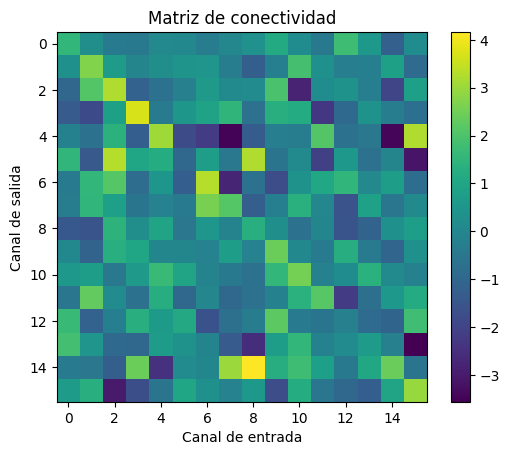

In [ ]:
with torch.no_grad():
  J = model_AKoRN.kblock.kconv.connectivity.weight.detach().cpu().numpy()

J_0 = J.sum(axis=(2,3))

plt.imshow(J_0)
plt.colorbar()
plt.title('Matriz de conectividad')
plt.xlabel('Canal de entrada')
plt.ylabel('Canal de salida')
plt.show()

In [ ]:
np.save("matriz_JO_riginal.npy", J_0)
#Quiero poner multiplicar J_0 por una matriz con numeros aleatorios de -1, 0,1. Cada uno con cierta probabilidad
#J_loaded = np.load("matriz_J.npy") Para cargar
np.random.seed(1)
np.random.randint(-1, 2, size=J_0.shape)

array([[ 0, -1, -1,  0,  0, -1, -1,  0, -1,  0, -1,  1,  0,  1, -1,  1],
       [ 0,  1, -1, -1,  1, -1,  0,  1,  1, -1,  0,  0,  1, -1,  1,  0],
       [ 0,  0,  0,  1,  0,  0, -1, -1,  0, -1, -1,  0,  1,  0, -1,  1],
       [ 1,  0,  0,  0, -1, -1,  0, -1,  1, -1, -1,  0,  0,  1, -1, -1],
       [ 0,  1,  1,  0, -1,  1,  0,  1,  0, -1,  0,  0,  1, -1, -1,  1],
       [ 1,  0, -1,  1,  1,  1, -1, -1,  0,  0,  0, -1, -1,  0,  0,  1],
       [-1,  0,  1,  1, -1,  0,  0, -1, -1, -1,  1, -1,  0, -1,  0, -1],
       [-1,  1, -1,  0,  1, -1,  0,  0, -1,  1, -1, -1, -1, -1,  0,  1],
       [-1,  0, -1,  1,  0,  1, -1, -1,  1,  1,  1, -1,  0,  1,  1,  1],
       [ 1, -1,  1,  0,  0,  1, -1,  1, -1,  1,  0,  0,  0,  1,  0,  0],
       [-1,  1, -1,  0, -1,  0,  0, -1,  0,  0,  0,  1,  0, -1, -1,  1],
       [ 0, -1, -1,  0,  1,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0],
       [-1,  1,  0, -1, -1,  1,  0, -1,  1,  1,  1, -1,  0,  0,  0,  0],
       [ 1, -1, -1,  1, -1,  0, -1,  1, -1,  1,  1,

##Accuracy

In [ ]:
model_AKoRN.eval()
correct_AKoRN = 0
accuracy_AKoRN=[]
with torch.no_grad():

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_AKoRN(data)
        pred = output.argmax(dim=1)
        correct_AKoRN += pred.eq(target).sum().item()
        print(f"Test Accuracy: {correct_AKoRN / len(test_dataset):.2%}")
        accuracy_AKoRN.append(correct_AKoRN / len(test_dataset))

Test Accuracy: 8.76%
Test Accuracy: 17.24%
Test Accuracy: 25.53%
Test Accuracy: 34.13%
Test Accuracy: 42.74%
Test Accuracy: 51.66%
Test Accuracy: 60.56%
Test Accuracy: 69.59%
Test Accuracy: 78.75%
Test Accuracy: 87.60%


# Aquí quiero evaluar la matriz Jij


In [ ]:
def evaluate_with_scaled_J(model, test_loader, scale, device):
    # 1. Guardar J original
    Jij_original = model.kblock.kconv.connectivity.weight.data.clone()

    # 2. Escalar J
    with torch.no_grad():
        model.kblock.kconv.connectivity.weight *= scale

    # 3. Evaluar
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(test_loader.dataset)

    # 4. Restaurar J
    with torch.no_grad():
        model.kblock.kconv.connectivity.weight.copy_(Jij_original)

    return accuracy


In [ ]:
scales = np.arange(-0.5, 1.5, 0.1)
Accuracy_list=[]
for s in scales:
    acc = evaluate_with_scaled_J(model_AKoRN, test_loader, s, device)
    Accuracy_list.append(acc)

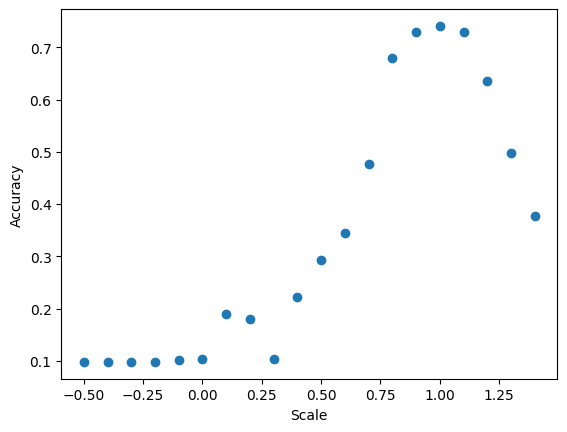

In [ ]:
plt.scatter(scales, Accuracy_list)
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.savefig('accuracy_scale.pdf')
plt.show()

# Red sin Kuramoto
Ahora quiero compararla con una red normal

##Arquitectura de la red

In [ ]:
class Simplemodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # Reemplazo de KBlock: otra convolución
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x


## Entrenamiento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simplemodel().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

n_epochs= 10
losses=[]
epochs= []
for epoch in range(n_epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epochs.append(epoch)
        losses.append(loss.item())
    print(f"{epoch+1}, Loss: {loss.item():.4f}")


KeyboardInterrupt: 

##Accuracy

In [ ]:
model.eval()
correct = 0
accuracy=[]
with torch.no_grad():

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        print(f"Test Accuracy: {correct / len(test_dataset):.2%}")
        accuracy.append(correct / len(test_dataset))


#Comparación entre las redes
Analizamos una red con AkorN y otra sin Akorn

In [ ]:

from scipy import stats


In [ ]:
accuracy=np.array(accuracy)*100
accuracy_AKoRN=np.array(accuracy_AKoRN)*100
walk_test= np.arange(0, len(accuracy),1)

In [ ]:
res= stats.linregress(walk_test,accuracy)
res_AKoRN= stats.linregress(walk_test,accuracy_AKoRN)


plt.plot(walk_test,accuracy, label= f'Sin AKoRN {round(res.slope,2)} ')
plt.plot(walk_test,accuracy_AKoRN, label = f'Con AKoRN {round(res_AKoRN.slope,2)}')

plt.xlabel('Test')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()
plt.savefig('accuracy.pdf')


##Matriz de confusión



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
 # Ponemos el modelo en modo evaluación
all_preds_AKoRN = []
all_labels_AKoRN = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_AKoRN(data)
        preds = output.argmax(dim=1)  # Elegimos la clase con mayor probabilidad
        all_preds_AKoRN.extend(preds.cpu().numpy())   # Convertimos a numpy
        all_labels_AKoRN.extend(target.cpu().numpy())


In [ ]:
cm_AKoRN= confusion_matrix(all_labels_AKoRN, all_preds_AKoRN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_AKoRN, display_labels=list(range(10)))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión para AKoRN en MNIST")
plt.savefig('confusion_matrix01.pdf')
plt.show()

In [ ]:
 # Ponemos el modelo en modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)  # Elegimos la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())   # Convertimos a numpy
        all_labels.extend(target.cpu().numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión sin AKoRN en MNIST")
plt.savefig('confusion_matrix01.pdf')
plt.show()

In [ ]:
from sklearn.metrics import recall_score


# Variando gamma
Analizamos el efecto de la sincronización en el aprendizaje, vale la pena mejorar la sincrinización? para qué mejorar la sincronización? donde es mejor hacer el ataque?

In [ ]:
import pandas as pd

In [ ]:

class AKoRNModel_mod(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.modrelu = ModReLU(n=2, ch=16)  # Reemplaza la ReLU estándar
        self.kblock = KBlock(n=2, ch=16, T=10, ksize=5)  # T=4 iteraciones dinámicas
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

    def forward(self, x, gamma= 1.0):
        x = self.conv1(x)
        x = self.modrelu(x)  # Aplica ModReLU en lugar de nn.ReLU()
        x, _ = self.kblock(x, x, T=10, gamma= gamma)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

n_epochs= 5
losses=[]
epochs= []
all_results = []

results = {}

init= 0.0
final= 1.0
walks= 0.1
gammas= np.arange(init,final+ walks,walks)
torch.manual_seed(42)

for gamma in gammas:
    torch.manual_seed(42)
    print(f"\nEntrenando con gamma = {gamma}")
    model = AKoRNModel_mod().to(device)  # reinicia el modelo
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(n_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, gamma=gamma)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {avg_loss:.4f} Accuracy: {accuracy:.2f}%")

        all_results.append({
            'gamma': gamma,
            'epoch': epoch,
            'loss': avg_loss,
            'accuracy': accuracy
        })

# cuando termine todo el entrenamiento
df = pd.DataFrame(all_results)
df.to_csv('resultados_gamma_epochs.csv', index=False)

print("\nResultados guardados en resultados_gamma_epochs.csv")


Entrenando con gamma = 0.0


# Teniendo en cuenta la sincronización

In [ ]:
class AKoRNModel_mod2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.modrelu = ModReLU(n=2, ch=16)
        self.kblock = KBlock(n=2, ch=16, T=10, ksize=5)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

    def forward(self, x, gamma=1.0, return_xs=False):
        x = self.conv1(x)
        x = self.modrelu(x)

        # 👇 Si se quiere extraer xs (activaciones por paso dinámico)
        if return_xs:
            x, xs = self.kblock(x, x, T=10, gamma=gamma, return_xs=True)
        else:
            x, _ = self.kblock(x, x, T=10, gamma=gamma)
            xs = None

        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)

        return x, xs  # ⬅️ Devuelve también xs para poder calcular r(t)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

n_epochs= 5
losses=[]
epochs= []
all_results = []

results = {}

init= 0.0
final= 1.0
walks= 0.1
gammas= np.arange(init,final+ walks,walks)
torch.manual_seed(42)

for gamma in gammas:
    torch.manual_seed(42)
    print(f"\nEntrenando con gamma = {gamma}")
    model = AKoRNModel_mod2().to(device)  # reinicia el modelo
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(n_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0
        sync_values = []  # para almacenar r(t) por batch

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output, xs = model(data, gamma=gamma, return_xs=True)
            r_batch = compute_sync_parameter(xs[-1], n=2)  # xs[-1] es el último paso
            sync_values.append(r_batch.mean().item())

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        avg_sync = np.mean(sync_values)

        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {avg_loss:.4f} Accuracy: {accuracy:.2f}% r(t): {avg_sync:.3f}")

        all_results.append({
            'gamma': gamma,
            'epoch': epoch,
            'loss': avg_loss,
            'accuracy': accuracy,
            'sync_r': avg_sync
        })

# cuando termine todo el entrenamiento
df = pd.DataFrame(all_results)
df.to_csv('resultados_sincronización.csv', index=False)

print("\nResultados guardados en resultados_gamma_epochs.csv")


Entrenando con gamma = 0.0
Epoch [1/5] Loss: nan Accuracy: 9.88% r(t): nan
Epoch [2/5] Loss: nan Accuracy: 9.87% r(t): nan
Epoch [3/5] Loss: nan Accuracy: 9.87% r(t): nan
Epoch [4/5] Loss: nan Accuracy: 9.87% r(t): nan
Epoch [5/5] Loss: nan Accuracy: 9.87% r(t): nan

Entrenando con gamma = 0.1
Epoch [1/5] Loss: 1.6924 Accuracy: 38.24% r(t): 0.380
Epoch [2/5] Loss: 1.1221 Accuracy: 62.41% r(t): 0.389
Epoch [3/5] Loss: 0.8086 Accuracy: 75.80% r(t): 0.374
Epoch [4/5] Loss: 0.6336 Accuracy: 81.53% r(t): 0.368
Epoch [5/5] Loss: 0.5100 Accuracy: 85.27% r(t): 0.368

Entrenando con gamma = 0.2
Epoch [1/5] Loss: 1.6166 Accuracy: 41.08% r(t): 0.479
Epoch [2/5] Loss: 1.0164 Accuracy: 66.45% r(t): 0.488
Epoch [3/5] Loss: 0.7174 Accuracy: 79.63% r(t): 0.458
Epoch [4/5] Loss: 0.5969 Accuracy: 84.15% r(t): 0.457
Epoch [5/5] Loss: 0.4499 Accuracy: 88.40% r(t): 0.456

Entrenando con gamma = 0.30000000000000004
Epoch [1/5] Loss: 1.5504 Accuracy: 45.63% r(t): 0.419
Epoch [2/5] Loss: 0.8800 Accuracy: 74.

In [ ]:
df = pd.read_csv('resultados_log.csv')

In [ ]:
df.dropna(inplace=True)

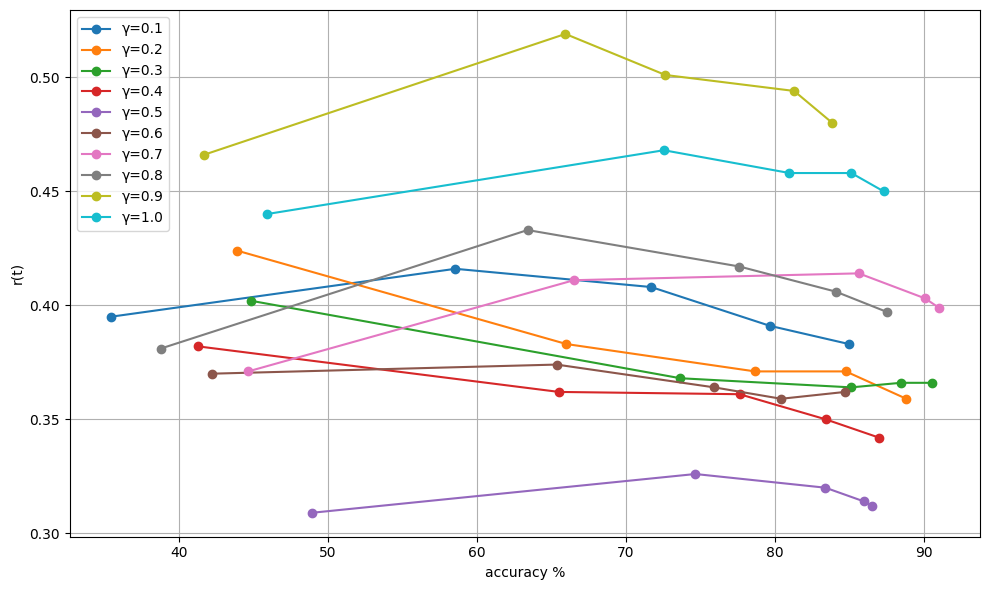

In [ ]:
gammas = sorted(df['gamma'].unique()) #[0,1,2,3,...]

plt.figure(figsize=(10, 6))

for g in gammas:
    data = df[df['gamma'] == g]
    plt.plot(data['accuracy'], data['sync_r'], marker='o', label=f'\u03B3={round(g,1)}')

plt.xlabel('accuracy %')
plt.ylabel('r(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Accuracy vs sincronización.pdf')
plt.show()

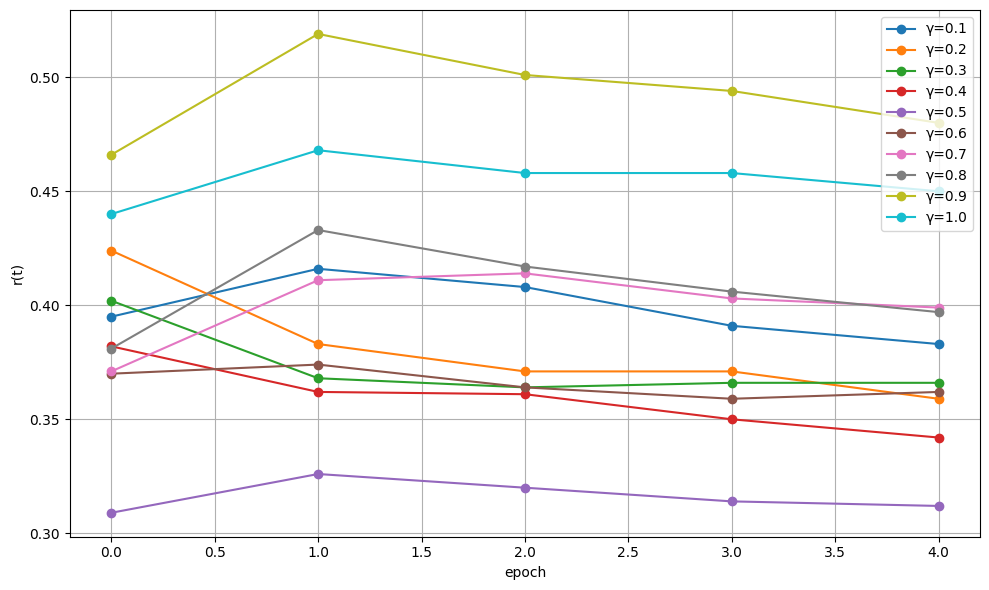

In [ ]:
gammas = sorted(df['gamma'].unique()) #[0,1,2,3,...]

plt.figure(figsize=(10, 6))

for g in gammas:
    data = df[df['gamma'] == g]
    plt.plot(data['epoch'], data['sync_r'], marker='o', label=f'\u03B3={round(g,1)}')

plt.xlabel('epoch')
plt.ylabel('r(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('r vs epoch.pdf')
plt.show()

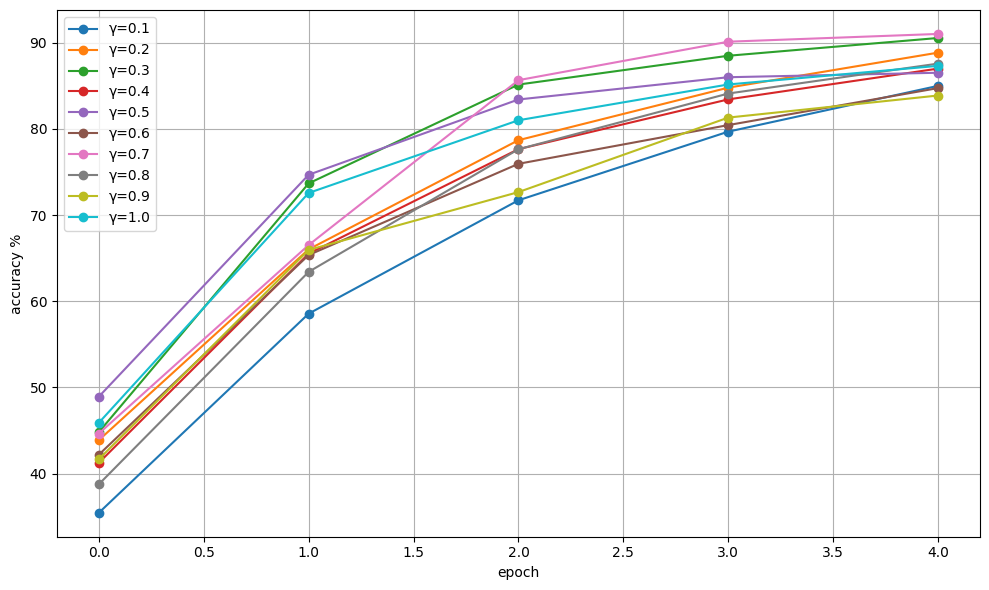

In [ ]:
gammas = sorted(df['gamma'].unique()) #[0,1,2,3,...]

plt.figure(figsize=(10, 6))

for g in gammas:
    data = df[df['gamma'] == g]
    plt.plot(data['epoch'], data['accuracy'], marker='o', label=f'\u03B3={round(g,1)}')

plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Accuracy vs epoch.pdf')
plt.show()

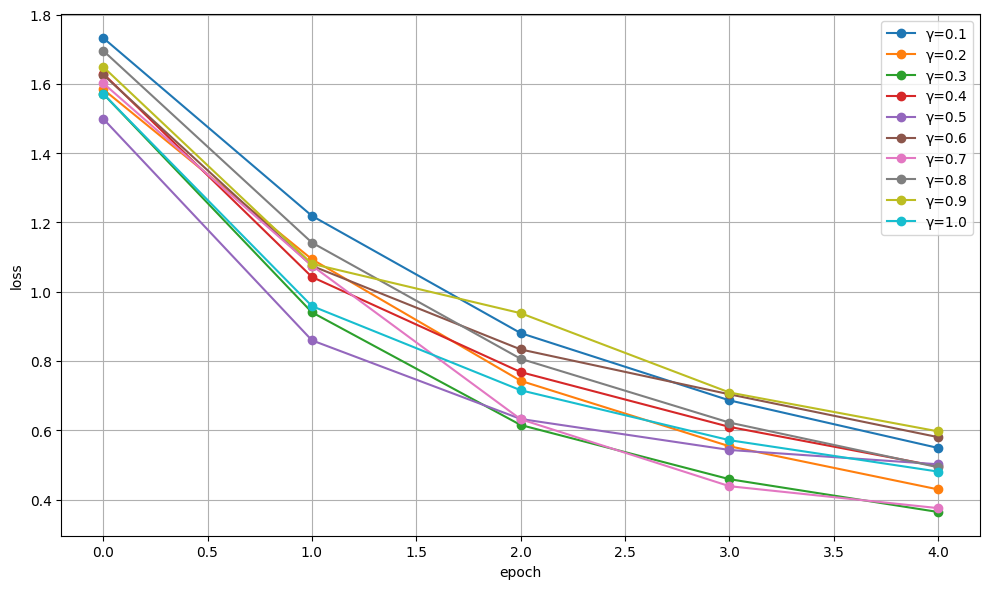

In [ ]:
gammas = sorted(df['gamma'].unique()) #[0,1,2,3,...]

plt.figure(figsize=(10, 6))

for g in gammas:
    data = df[df['gamma'] == g]
    plt.plot(data['epoch'], data['loss'], marker='o', label=f'\u03B3={round(g,1)}')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('epoch vs loss.pdf')
plt.show()

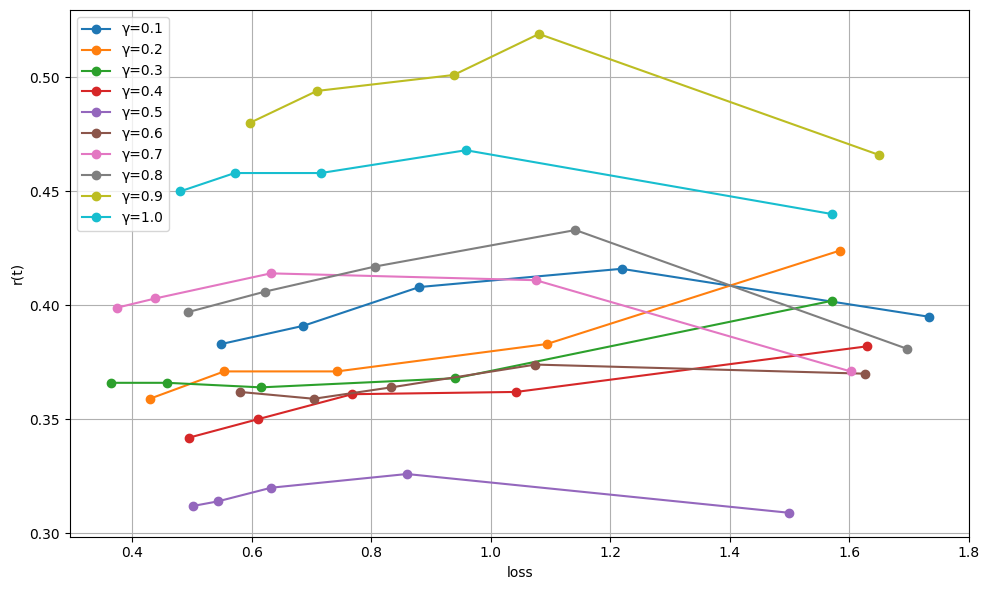

In [ ]:
gammas = sorted(df['gamma'].unique()) #[0,1,2,3,...]

plt.figure(figsize=(10, 6))

for g in gammas:
    data = df[df['gamma'] == g]
    plt.plot(data['loss'], data['sync_r'], marker='o', label=f'\u03B3={round(g,1)}')

plt.xlabel('loss')
plt.ylabel('r(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('r vs loss.pdf')
plt.show()